# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

качество предсказания;

скорость предсказания;

время обучения.

Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.

2. Обучите разные модели с различными гиперпараметрами.

3. Проанализируйте скорость работы и качество моделей.

Примечания:

Для оценки качества моделей применяйте метрику RMSE.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
Скопировать код: del features_train

## Подготовка данных

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, Ridge
from matplotlib import pyplot as plt
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest


rnd_state = 12345
data  = pd.read_csv('/datasets/autos.csv')


In [39]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [40]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [41]:
data.shape

(354369, 16)

In [42]:
#Price
# Странно если стоимоcть машины, менее предположим 200 евро
data.loc[data['Price']<=200, 'Price'] = 0

In [43]:
#RegistrationYear
print("Процент данных с ошибками по годам: {:.2%}".format(data
                                                          .query('RegistrationYear<1950 or RegistrationYear>2019')
                                                          .shape[0] / data.shape[0]))


Процент данных с ошибками по годам: 0.10%


In [44]:
#Удалим аномальные значение в столбце RegistrationYear
data = data.loc[(data['RegistrationYear']>1950) & (data['RegistrationYear']<2020)]

In [45]:
#количество автомобилей с нулевой мощностью: 
data[data['Power']==0].shape[0]

39960

In [46]:
#Удалим аномальные значение в столбце Power
data = data.loc[(data['Power']>69) & (data['Power']<20000)]

In [47]:
data.shape

(262285, 16)

In [48]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          17972
RegistrationYear         0
Gearbox               4492
Power                    0
Model                10688
Kilometer                0
RegistrationMonth        0
FuelType             16550
Brand                    0
NotRepaired          39213
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [49]:
columns_isnull = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

In [50]:
data[columns_isnull] = data[columns_isnull].fillna('Nan')

In [51]:
data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [52]:
data.duplicated().sum()

4

In [53]:
data = data.drop_duplicates().reset_index(drop=True)

In [54]:
data.duplicated().sum()

0

In [55]:
columns_drop = ['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures']
data = data.drop(columns=columns_drop)

In [56]:
data.duplicated().sum()

16738

In [57]:
data = data.drop_duplicates().reset_index(drop=True)

In [58]:
data.duplicated().sum()

0

## Обучение моделей

In [59]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

In [60]:
data_train, data_valid = train_test_split(data_ohe, test_size=0.2, random_state=rnd_state)
data_valid, data_test = train_test_split(data_valid , test_size=0.2, random_state=rnd_state)

In [61]:
features_train = data_train.drop(columns=['Price'])
target_train = data_train['Price']

features_valid = data_valid.drop(columns=['Price'])
target_valid = data_valid['Price']

features_test = data_test.drop(columns=['Price'])
target_test = data_test['Price']

In [62]:
def model_eval(model, features_train, target_train, features_test, target_test):
    
    start = time.time()    
    model.fit(features_train, target_train)
    training_time = time.time() - start
    
    start = time.time()  
    target_pred = model.predict(features_test)
    predict_time = time.time() - start

    return training_time, predict_time

In [63]:
model = LinearRegression()

start_time = time.time()
model.fit(features_train, target_train)

training_time_lr = model_eval(model, features_train, target_train, features_test, target_test)

predict_lr = pd.DataFrame(model.predict(features_valid))
score_lr = mean_squared_error(target_valid, predict_lr) ** 0.5

print("RMSE LinearRegression:", score_lr)
print("Время обучения LinearRegression:", training_time_lr)

RMSE LinearRegression: 2913.4924692719824
Время обучения LinearRegression: (32.38462972640991, 0.12308812141418457)


In [64]:
from collections import defaultdict
d = defaultdict(list)

lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20, random_state=rnd_state)
start_time = time.time()
lgbm_model.fit(features_train, target_train)

training_time_lgbm = model_eval(model, features_train, target_train, features_test, target_test)

predict_lgbm = pd.DataFrame(lgbm_model.predict(features_valid))
score_lgbm = mean_squared_error(target_valid, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", score_lgbm)
print("Время обучения LGBMRegressor:", training_time_lgbm)

RMSE LGBMRegressor: 2842.359184052741
Время обучения LGBMRegressor: (57.78791356086731, 0.02773427963256836)


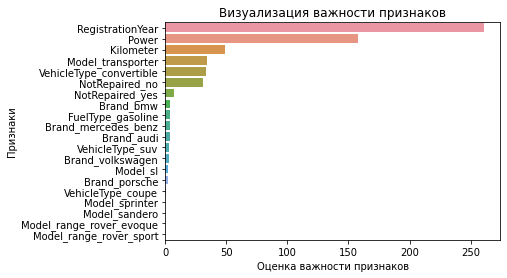

In [65]:
import seaborn as sns
def chart_feature_imp(cat_model):
    feature_imp = pd.Series(cat_model.feature_importances_, index=features_valid.columns).sort_values(ascending=False).head(20)
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(lgbm_model)

In [66]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state)
start_time = time.time()
cat_model.fit(features_train, target_train, verbose=10)

training_time_cat = model_eval(model, features_train, target_train, features_test, target_test)

predict_cat = cat_model.predict(features_valid)
score_cat = mean_squared_error(target_valid, predict_cat) ** 0.5

print("RMSE CatBoostRegressor:", score_cat)
print("Время обучения CatBoostRegressor:", training_time_cat)

Learning rate set to 0.5
0:	learn: 3441.1563412	total: 36.2ms	remaining: 1.77s
10:	learn: 2131.1649064	total: 299ms	remaining: 1.06s
20:	learn: 2027.8015942	total: 577ms	remaining: 796ms
30:	learn: 1973.3456918	total: 838ms	remaining: 513ms
40:	learn: 1939.9450274	total: 1.09s	remaining: 240ms
49:	learn: 1912.2432685	total: 1.35s	remaining: 0us
RMSE CatBoostRegressor: 1932.4843849957513
Время обучения CatBoostRegressor: (55.05729150772095, 0.12639117240905762)


In [67]:
cat_features = [i for i, (col, ser) in enumerate(data.iteritems()) if ser.dtype == object]


pool = Pool(data=data.iloc[:, :-1].values, label=data.iloc[:, -1].values, cat_features=cat_features)

cat_model=CatBoostRegressor(iterations=50, verbose=True)
cat_model.fit(pool)

shap_values = cat_model.get_feature_importance(data=pool, fstr_type='ShapValues')

print(shap_values)

Learning rate set to 0.5
0:	learn: 25789.2887357	total: 138ms	remaining: 6.76s
1:	learn: 25734.1214536	total: 233ms	remaining: 5.6s
2:	learn: 25705.0753680	total: 333ms	remaining: 5.21s
3:	learn: 25690.0865721	total: 432ms	remaining: 4.97s
4:	learn: 25681.3272798	total: 532ms	remaining: 4.79s
5:	learn: 25665.3216175	total: 628ms	remaining: 4.6s
6:	learn: 25660.8170682	total: 730ms	remaining: 4.48s
7:	learn: 25654.5729962	total: 827ms	remaining: 4.34s
8:	learn: 25653.5681256	total: 879ms	remaining: 4s
9:	learn: 25646.7687959	total: 969ms	remaining: 3.88s
10:	learn: 25642.1486414	total: 1.06s	remaining: 3.77s
11:	learn: 25641.7614662	total: 1.11s	remaining: 3.52s
12:	learn: 25637.9068766	total: 1.21s	remaining: 3.46s
13:	learn: 25635.9256077	total: 1.33s	remaining: 3.42s
14:	learn: 25630.5081745	total: 1.45s	remaining: 3.37s
15:	learn: 25627.0435634	total: 1.57s	remaining: 3.33s
16:	learn: 25624.6749578	total: 1.67s	remaining: 3.25s
17:	learn: 25619.7521229	total: 1.78s	remaining: 3.16s


In [68]:
cat_model.feature_importances_.shape

(11,)

In [69]:
features_valid.columns.shape

(309,)

In [71]:
import seaborn as sns
def chart_feature_imp(cat_model):
    feature_imp = pd.Series(cat_model.feature_importances_, index=features_valid.columns).sort_values(ascending=False).head(20)
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(cat_model)

ValueError: Length of passed values is 11, index implies 309.

Вывод:

Применили для категориальных признаков метод OHE

Рассмотрели три алгоритма классификации: CatBoostRegressor, LGBMRegressor, Линейная регрессия

Модель "CatBoostRegressor" наиболее подходящая для решения дальнейшей задачи

## Анализ моделей

In [72]:
data_time = pd.Series({'LinearRegression': training_time_lr,
                           'LightGBM': training_time_lgbm,
                           'CatBoost': training_time_cat}) 

data_time

LinearRegression    (32.38462972640991, 0.12308812141418457)
LightGBM            (57.78791356086731, 0.02773427963256836)
CatBoost            (55.05729150772095, 0.12639117240905762)
dtype: object

In [73]:
data_score = pd.Series({'LinearRegression': score_lr,
                           'LightGBM': score_lgbm,
                           'CatBoost': score_cat}) 

data_score

LinearRegression    2913.492469
LightGBM            2842.359184
CatBoost            1932.484385
dtype: float64

In [74]:
features_test = data_ohe.drop('Price', axis=1)
target_test = data_ohe['Price']

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state)
start_time = time.time()
cat_model.fit(features_train, target_train, verbose=10)
training_time_cat = model_eval(model, features_train, target_train, features_test, target_test)

predict_cat = cat_model.predict(features_test)
score_cat = mean_squared_error(target_test, predict_cat) ** 0.5

print("RMSE CatBoostRegressor:", score_cat)
print("Время обучения CatBoostRegressor:", training_time_cat)

Learning rate set to 0.5
0:	learn: 3441.1563412	total: 41.4ms	remaining: 2.03s
10:	learn: 2131.1649064	total: 454ms	remaining: 1.61s
20:	learn: 2027.8015942	total: 772ms	remaining: 1.07s
30:	learn: 1973.3456918	total: 1.07s	remaining: 654ms
40:	learn: 1939.9450274	total: 1.36s	remaining: 298ms
49:	learn: 1912.2432685	total: 1.62s	remaining: 0us
RMSE CatBoostRegressor: 1917.0540858004747
Время обучения CatBoostRegressor: (62.238306760787964, 0.9099371433258057)
